# PD Model

In [1]:
#import libraries
#libraries for loading data
import pandas as pd
import numpy as np

#libraries for visualization
import matplotlib.pyplot as plt
import seaborn as sns



#libraries for logistic machine learning regression
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

#libraries for random forest machine learning
from sklearn.ensemble import RandomForestClassifier

In [2]:
# load data
df = pd.read_csv('data/loan_status_clean_df.csv')

In [3]:
# Create good_bad variable
df['good_bad'] = np.where(df['loan_status'].isin(['Charged Off', 'Default',
                                                       'Does not meet the credit policy. Status:Charged Off',
                                                       'Late (31-120 days)']), 0, 1)

In [4]:
df.good_bad.value_counts()

good_bad
1    138468
0     19774
Name: count, dtype: int64

In [9]:
# create function for creating woe and iv data sets and respective plots for each feature
# BhishanPoudel at https://stackoverflow.com/questions/60892714/how-to-get-the-weight-of-evidence-woe-and-information-value-iv-in-python-pan

def woe_iv(df, feature, target):

    #create table woe and iv for categorized in function of the feature
    df_woe_iv = (pd.crosstab(df[feature],df[target],
                      normalize='columns')
             .assign(woe=lambda dfx: np.log(dfx[1] / dfx[0]))
             .assign(iv=lambda dfx: np.sum(dfx['woe']*
                                           (dfx[1]-dfx[0])))
                .reset_index())
    df_woe_iv = df_woe_iv.sort_values('woe')
    return df_woe_iv

In [12]:
def graph_woe(df_woe_iv, feature):
    # create the line graph of woe and iv
    fig = plt.figure(figsize=(18,6))
    plt.title('WOE for ' + feature)
    sns.lineplot(data=df_woe_iv, x=feature, y='woe', marker='o')
    plt.xlabel(feature)
    plt.ylabel('WOE')
    if len(df_woe_iv[feature].unique()) >= 10:
        rot = 90
    elif len(df_woe_iv[feature].unique()) <10:
        rot = 0
    plt.xticks(rotation=rot)

    return fig

In [13]:
# create list of features: caterogical variables
categorical_features = ['grade', 'sub_grade', 'home_ownership', 'verification_status',
                        'purpose', 'addr_state', 'initial_list_status']

c:\Anaconda\envs\edu\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Anaconda\envs\edu\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Anaconda\envs\edu\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Anaconda\envs\edu\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with

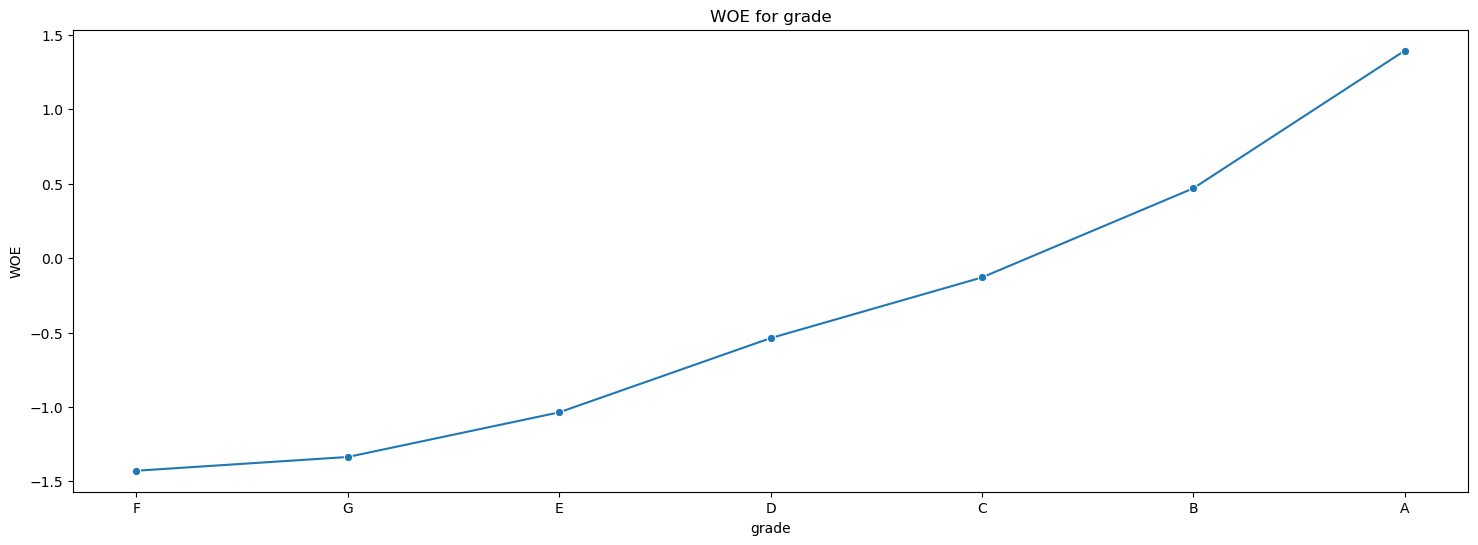

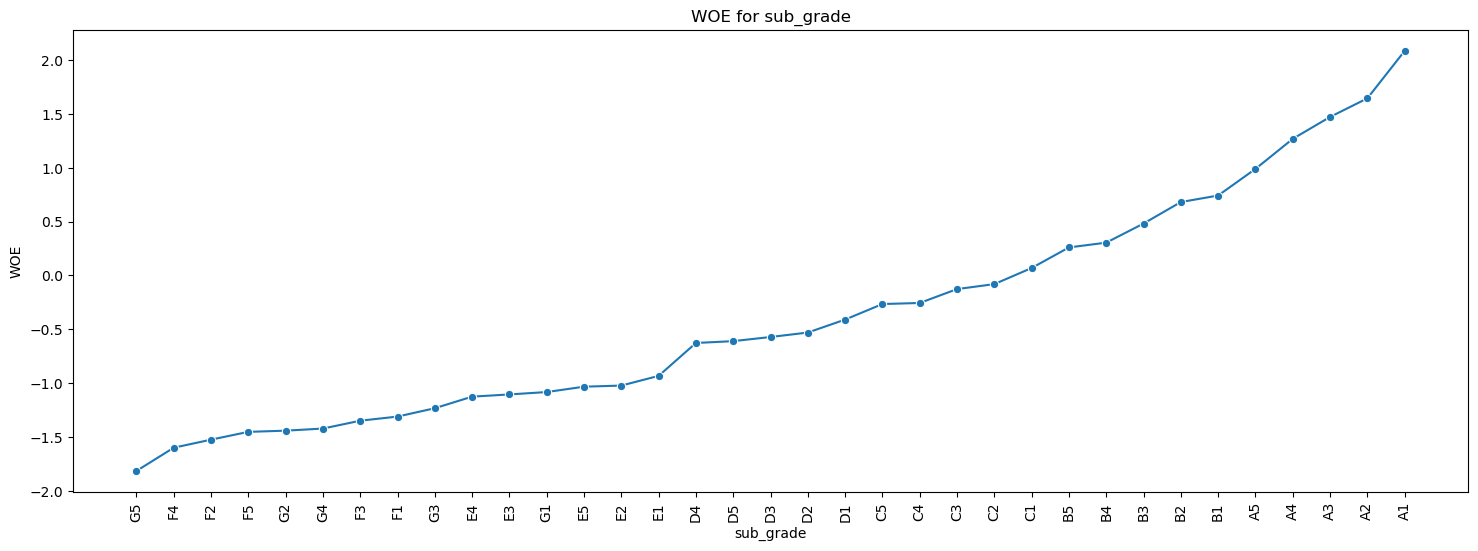

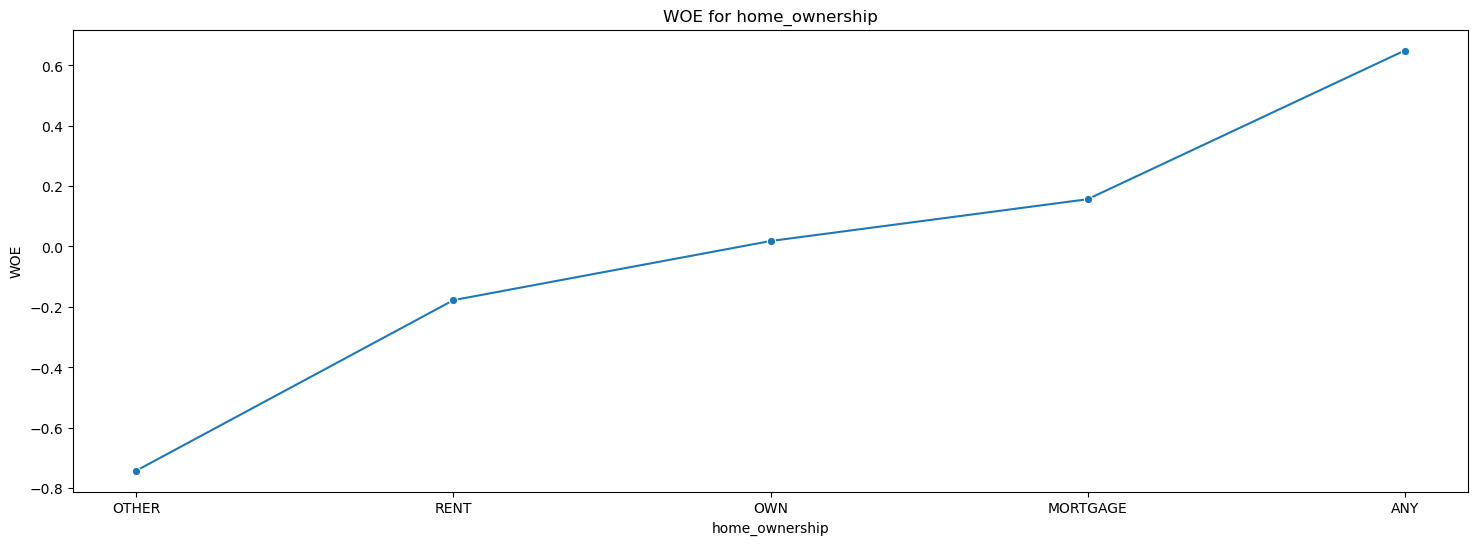

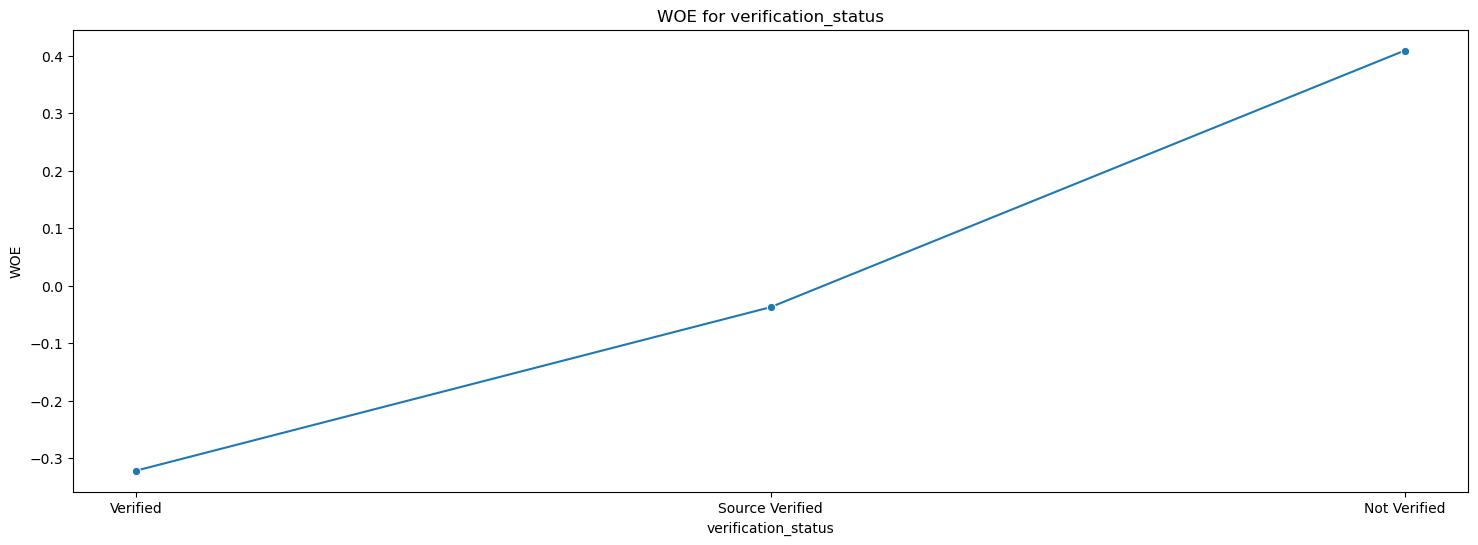

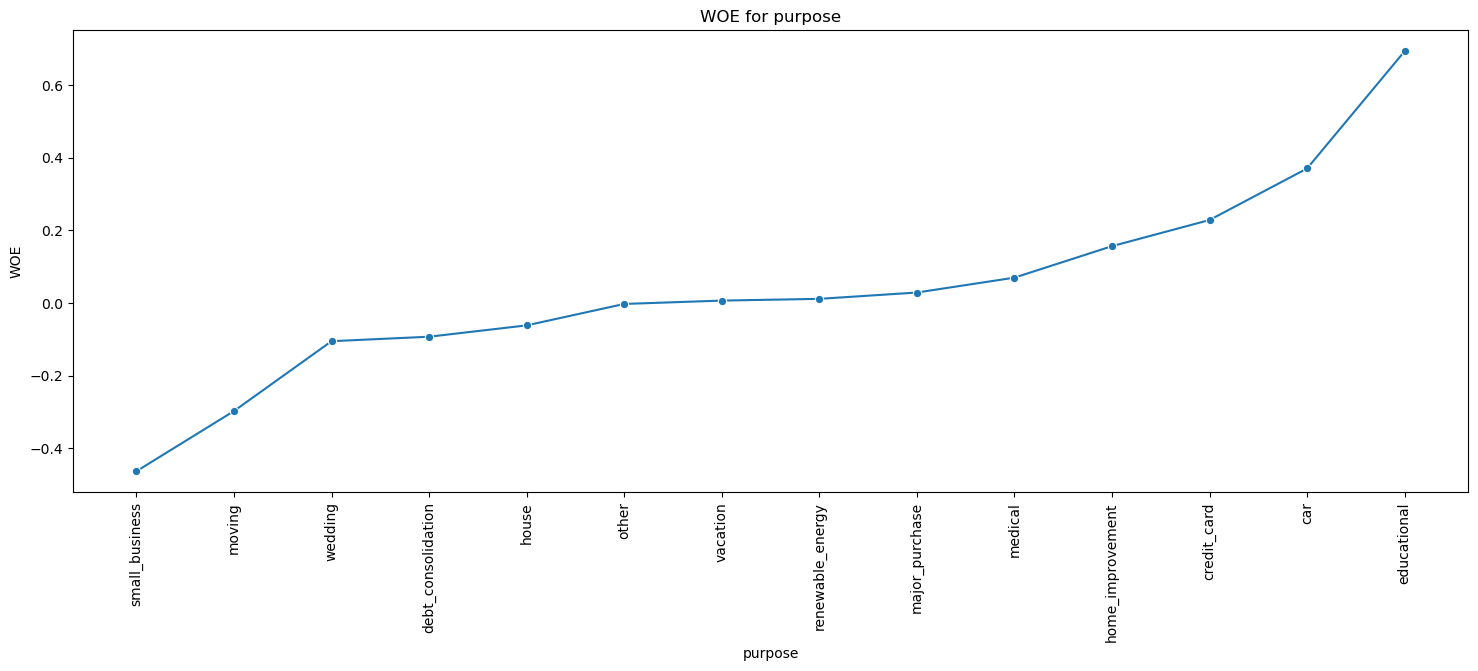

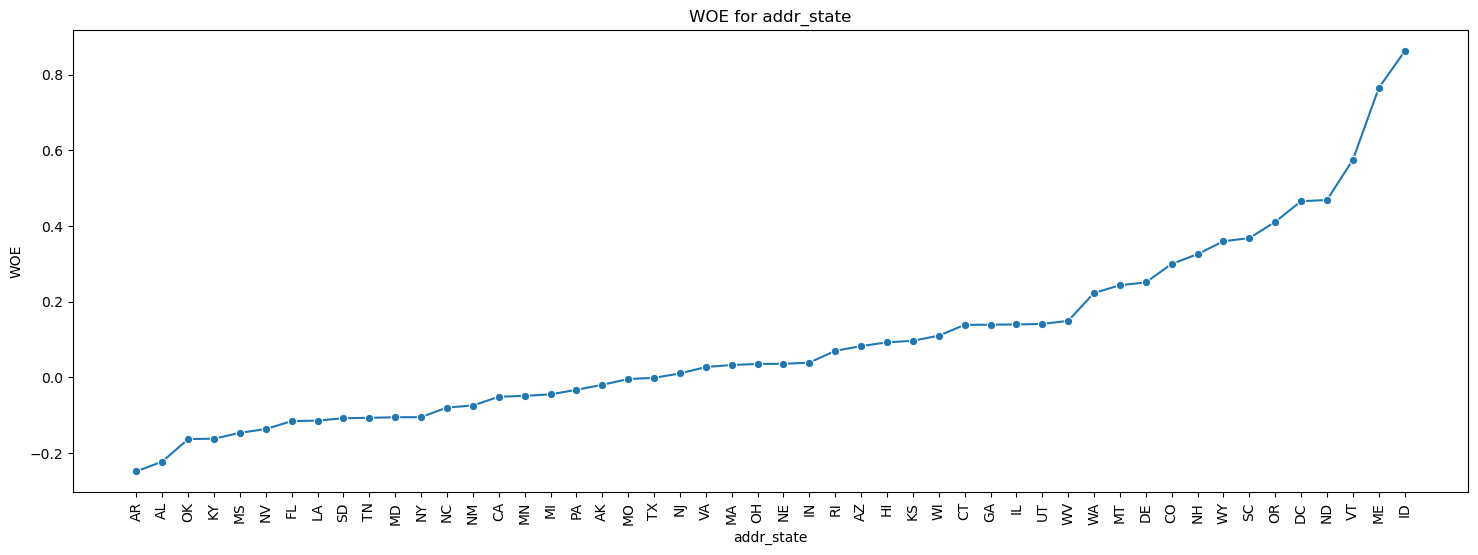

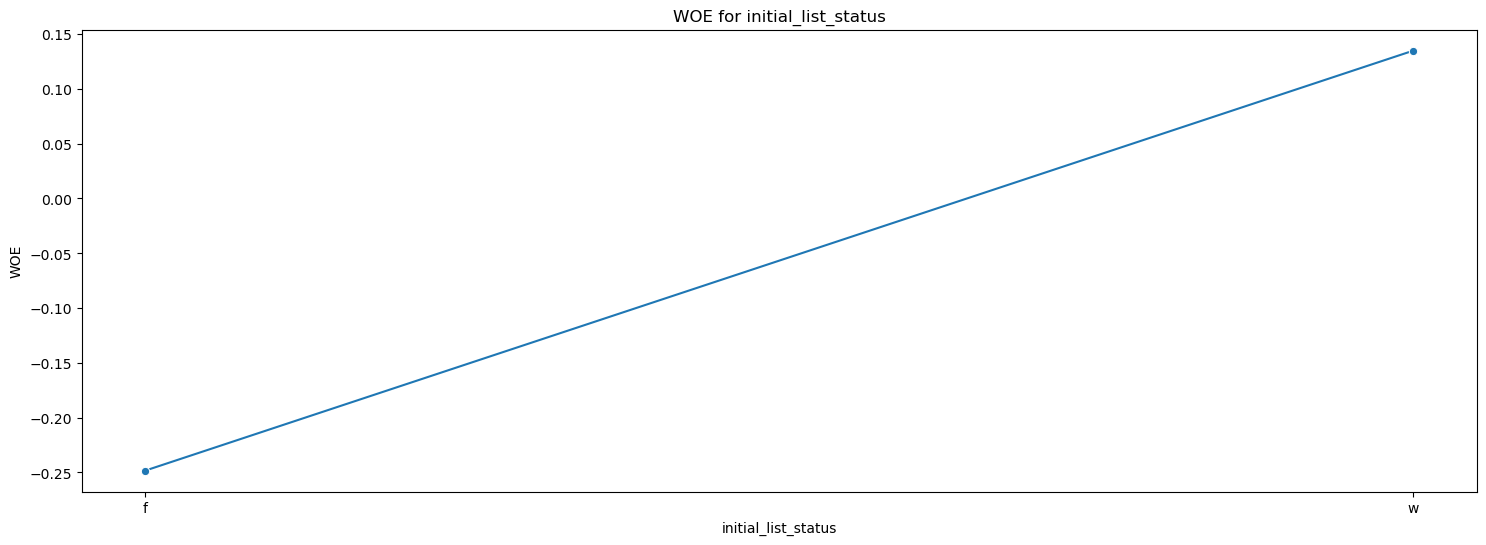

In [14]:
list_graphs_woe = []
for cat in categorical_features:
    df_woe_iv = woe_iv(df, cat, 'good_bad')
    list_graphs_woe.append(graph_woe(df_woe_iv, cat))


In [15]:
df.head()

,grade,sub_grade,home_ownership,verification_status,purpose,addr_state,initial_list_status,grade:B,grade:C,grade:D,...,emp_length,grade.1,sub_grade.1,home_ownership.1,verification_status.1,purpose.1,addr_state.1,initial_list_status.1,loan_status,good_bad
0,A,A4,MORTGAGE,Source Verified,debt_consolidation,KS,f,False,False,False,...,2.0,A,A4,MORTGAGE,Source Verified,debt_consolidation,KS,f,Fully Paid,1
1,C,C4,RENT,Source Verified,debt_consolidation,AZ,f,False,True,False,...,2.0,C,C4,RENT,Source Verified,debt_consolidation,AZ,f,Current,1
2,C,C2,RENT,Source Verified,debt_consolidation,WI,f,False,True,False,...,6.0,C,C2,RENT,Source Verified,debt_consolidation,WI,f,Fully Paid,1
3,C,C3,RENT,Not Verified,debt_consolidation,VA,w,False,True,False,...,10.0,C,C3,RENT,Not Verified,debt_consolidation,VA,w,Late (16-30 days),1
4,C,C5,RENT,Verified,home_improvement,TX,f,False,True,False,...,2.0,C,C5,RENT,Verified,home_improvement,TX,f,Charged Off,0


In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 158242 entries, 0 to 158241
Columns: 133 entries, grade to good_bad
dtypes: bool(110), float64(7), int32(1), object(15)
memory usage: 43.8+ MB


In [17]:
#create a df with only the features that will be used in the model and the target
#select the the categorical variables, transform them into dummies and drop the original columns
list_num_vars = ['acc_now_delinq','total_acc','pub_rec','open_acc','inq_last_6mths','delinq_2yrs','emp_length']
categorical_features = ['grade', 'sub_grade', 'home_ownership', 'verification_status',
                        'purpose', 'addr_state', 'initial_list_status']

df_model = pd.concat([df[list_num_vars], pd.get_dummies(df[categorical_features], drop_first=True), df['good_bad']], axis=1)

## ML Model

In [36]:
#balance the data
#select the number of rows of the minority class
n = df_model.good_bad.value_counts().min()
m = df_model.good_bad.value_counts().max()

from sklearn.utils import resample

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(df_model.drop('good_bad', axis=1), df_model['good_bad'], test_size=0.2, random_state=42)

# Concatenate our training data back together
X = pd.concat([X_train, y_train], axis=1)

# Separate minority and majority classes
majority = X[X.good_bad==1]
minority = X[X.good_bad==0]

# Upsample minority
minority_upsampled = resample(minority,
                          replace=True, # sample with replacement
                          n_samples=len(majority), # match number in majority class
                          random_state=42) # reproducible results

# Combine majority and upsampled minority
upsampled = pd.concat([majority, minority_upsampled])

# Check new class counts
upsampled.good_bad.value_counts()



good_bad
1    110761
0    110761
Name: count, dtype: int64

good_bad
1    110761
0    110761
Name: count, dtype: int64

In [20]:
#split the data into train and test
def split_data(df, target):
    X = df.drop(target, axis=1)
    y = df[target]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=101)
    return X_train, X_test, y_train, y_test

In [21]:
#build logistic regression model
def logistic_regression_model(X_train, X_test, y_train, y_test):
    logmodel = LogisticRegression()
    logmodel.fit(X_train, y_train)
    predictions = logmodel.predict(X_test)
    new_func(y_test, predictions)
    return logmodel

def new_func(y_test, predictions):
    print(classification_report(y_test, predictions))
    print(confusion_matrix(y_test, predictions))
    print(accuracy_score(y_test, predictions))

In [44]:
X_test

<class 'pandas.core.frame.DataFrame'>
Index: 31649 entries, 84964 to 32427
Columns: 117 entries, acc_now_delinq to initial_list_status_w
dtypes: bool(110), float64(7)
memory usage: 5.3 MB


In [43]:
logistic_regression_model(upsampled.drop('good_bad', axis=1), X_test, upsampled['good_bad'], y_test)

              precision    recall  f1-score   support

           0       0.21      0.66      0.31      3942
           1       0.93      0.64      0.75     27707

    accuracy                           0.64     31649
   macro avg       0.57      0.65      0.53     31649
weighted avg       0.84      0.64      0.70     31649

[[ 2614  1328]
 [10111 17596]]
0.6385667793611173


c:\Anaconda\envs\edu\Lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()